In [1]:
import pickle
import numpy as np
import seaborn as sns # ?????
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import matplotlib.pylab as plt
import tqdm
import math
from copy import deepcopy
%matplotlib inline

# Загружаем датасет

In [2]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)


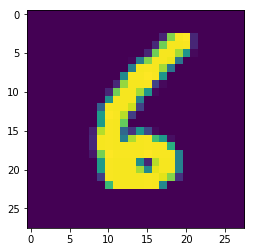

In [3]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][50].reshape(28,28))

# Обучаем модель

In [4]:
# Реализуйте здесь обучение модели
#plt.style.use('seaborn')
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

x_train, y_train = train['data'], train['labels']
x_test = test_no_lables['data']

def zero_one_normalize(x):
    for i,pixel in enumerate(x):
        x[i] = pixel/(128)
    return x

def z_score_normalize(x):
    for i in range(x.shape[0]):
        mean = np.mean(x[i], axis=0)
        std = np.std(x[i], axis=0)
        x[i] = (x[i] - mean)/std
    return x

y_train[y_train==6] = 1
y_train[y_train==5] = 0
x_train = zero_one_normalize(x_train)
#x_train = z_score_normalize(x_train)

In [5]:
print(x_train[0].reshape(28,28))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 

In [6]:
k_5 = 0
k_6 = 0
x_train_5 = np.ndarray((x_train.shape[0], x_train.shape[1]))
y_train_5 = np.ndarray((y_train.shape[0]))
x_train_6 = np.ndarray((x_train.shape[0], x_train.shape[1]))
y_train_6 = np.ndarray((y_train.shape[0]))
for i in range(y_train.shape[0]):
    if y_train[i] == 0:
        x_train_5[k_5] = x_train[i]
        y_train_5[k_5] = y_train[i]
        k_5 += 1
    elif y_train[i] == 1:
        x_train_6[k_6] = x_train[i]
        y_train_6[k_6] = y_train[i]
        k_6 += 1

In [7]:
# Инициализируем веса случайны образом
np.random.seed(11)
w_5 = np.random.normal(scale=0.001, size = x_train_5.shape[1])
w_6 = np.random.normal(scale=0.001, size = x_train_6.shape[1])

In [8]:
def logloss(w, x, y):
    return np.log(1 + np.exp(- y * np.dot(w.T, x)))

In [9]:
logloss_array = np.ndarray((x_train.shape[0],x_train.shape[0]))
def grad(w, x_train, y_train):
    global logloss_array
    for iter in tqdm.tqdm_notebook(range(100)):
        for i in range(x_train.shape[0]):
            j = np.random.randint(0, x_train.shape[0])
            grad = - y_train[j] * x_train[j] / \
                ( 1 + math.exp( y_train[j] * np.dot(w.T, x_train[j]) ) ) + 0 * w
            w = w - 0.01 * grad
            logloss_array[i] = logloss(w, x_train[j], y_train[j]) 
            
grad(w_5, x_train_5, y_train_5)
grad(w_6, x_train_6, y_train_6)

In [10]:
def predict(w):
    p = (1. / (1. + np.exp(-np.dot(x_test, w))))
    return p

p5 = predict(w_5)
p6 = predict(w_6)
    
print(p5)
print(p6)





[0.33619625 0.86233074 0.65506942 ... 0.12592348 0.10905145 0.66785902]
[0.06185519 0.1980666  0.49110551 ... 0.57038277 0.63200061 0.02775446]


In [11]:
print(train['labels'])


[0. 0. 1. ... 1. 0. 1.]


# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

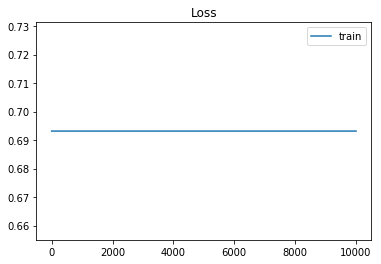

In [13]:
plt.title('Loss')
plt.plot(logloss_array[0], label='train')
#plt.plot([e[0] for e in te_eval], label='test')
plt.legend()

In [ ]:
"""
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend()
"""

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [ ]:
X = test_no_lables['data']

# compute Y_pred

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(test['labels'])):
        print(i, Y_pred[i], sep=',', file=fout)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МИФИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем family.ipynb